In [1]:
import pandas as pd
import json
import requests
import vcf
from urllib.parse import urljoin

In [2]:
EXAC_HOST = 'http://exac.hms.harvard.edu'
EXAC_BULK_VARIANT_ENDPOINT = '/rest/bulk/variant'
vcf_filename = 'data/Challenge_data.vcf'
output_column_order = [
    'chrom',
    'pos',
    'ref',
    'alt',
    'variant_type',
    'read_depth',
    'alt_allele_obs',
    'alt_allele_obs_percentage',
    'variant_str',
    'exac_allele_count',
    'exac_allele_freq',
    'exac_allele_num',
    'exac_hom_count',
    'exac_pop_acs',
    'exac_pop_ans',
    'exac_pop_homs',
    'exac_vep_annotations'
]

In [3]:
def _get_exac_annotations(all_variant_strs, output_filename=None):
    """
    Wrapper function for calling ExAC API. 
    
    Optionally writes annotations to file if `output_filename` is specified.
    """
    
    response = requests.post(
        urljoin(EXAC_HOST, EXAC_BULK_VARIANT_ENDPOINT), 
        json=all_variant_strs)
    response.raise_for_status()
    response_json = response.json()
    
    if output_filename is not None:
        with open(output_filename, 'w') as exac_file:
            json.dump(response_json, exac_file)
    
    return response_json


def get_exac_annotations(all_variant_strs):
    """
    Returns DataFrame of relevant ExAC annotations for each variant.
    """
    
    exac_annotations = _get_exac_annotations(all_variant_strs, 
                                             output_filename='data/exac_annotations.json')
    
    relevant_exac_annotations = []

    for variant_str, value in exac_annotations.items():
        variant = value['variant']
        relevant_exac_annotations_for_variant = {
            'variant_str': variant_str,
            'exac_allele_count': variant['allele_count'] if 'allele_count' in variant else '',
            'exac_allele_num': variant['allele_num'] if 'allele_num' in variant else '',
            'exac_allele_freq': variant['allele_freq'] if 'allele_freq' in variant else '',
            'exac_hom_count': variant['hom_count'] if 'hom_count' in variant else '',
            'exac_pop_acs': variant['pop_acs'] if 'pop_acs' in variant else '',
            'exac_pop_ans': variant['pop_ans'] if 'pop_ans' in variant else '',
            'exac_pop_homs': variant['pop_homs'] if 'pop_homs' in variant else '',
            'exac_vep_annotations': variant['vep_annotations'] if 'vep_annotations' in variant else '',
        }

        relevant_exac_annotations.append(relevant_exac_annotations_for_variant)
        
    exac_df = pd.DataFrame.from_records(relevant_exac_annotations)
    return exac_df


def add_exac_annotations(df):
    """
    Takes as input a DataFrame `df` with columns `chrom`, `pos`, `ref`, `alt`.
    
    Returns DataFrame with exac annotations added.
    """
    df['variant_str'] = df.apply(lambda row: "{}-{}-{}-{}".format(
        row.chrom, row.pos, row.ref, row.alt), axis=1)
    
    all_variant_strs = list(df['variant_str'])
    exac_df = get_exac_annotations(all_variant_strs)
    
    df_with_exac = df.join(exac_df.set_index('variant_str'), on='variant_str')
    return df_with_exac

In [4]:
def parse_vcf(vcf_filename):
    """
    Parses VCF file and returns DataFrame of all alleles annotated with the following information:
            - Variant type
            - Read depth at site of the variation
            - Number of reads supporting the variant
            - Percentage of reads supporting the variant versus those supporting reference reads
    """

    vcf_reader = vcf.Reader(open(vcf_filename, 'r'))

    all_annotations = []

    for record in vcf_reader:
        chrom = record.CHROM
        pos = record.POS
        ref = record.REF
        alts = record.ALT
        variant_type = record.INFO['TYPE']
        read_depth = record.INFO['DP']
        alt_allele_obs = record.INFO['AO']
        ref_allele_obs = record.INFO['RO']
        alt_allele_obs_percentage = [num_obs / (num_obs + ref_allele_obs) 
                                     for num_obs in alt_allele_obs]

        for idx, alt in enumerate(alts):
            # TODO: Normalize variant

            annotations = {
                'chrom': chrom,
                'pos': pos,
                'ref': ref,
                'alt': alt,
                'variant_type': variant_type[idx],
                'read_depth': read_depth,
                'alt_allele_obs': alt_allele_obs[idx],
                'alt_allele_obs_percentage': alt_allele_obs_percentage[idx],
            }

            all_annotations.append(annotations)

    df = pd.DataFrame.from_records(all_annotations)
    return df

In [5]:
# Annotate variants from VCF and ExAC
df = parse_vcf(vcf_filename)
df_with_exac = add_exac_annotations(df)

In [6]:
# Output annotations to csv file
df_with_exac.to_csv('results/Challenge_data_annotated.csv', 
                    index=False, 
                    header=output_column_order, 
                    columns=output_column_order)

In [12]:
# Sanity Checks
vcf_reader = vcf.Reader(open(vcf_filename, 'r'))

# Check read_depth is greater than or equal to the total number of alt alleles + number of reference alleles observed at a given site
for record in vcf_reader:
    read_depth = record.INFO['DP']
    alt_allele_obs = record.INFO['AO']
    ref_allele_obs = record.INFO['RO']
        
    assert read_depth >= sum(alt_allele_obs) + ref_allele_obs, "{} should not be less than {} : {}".format(read_depth, sum(alt_allele_obs) + ref_allele_obs, record)

# Validate that we are using hg19 because ExAC API assumes we are using hg19 coordinates.
assert 'v37' in vcf_reader.metadata['reference'] 

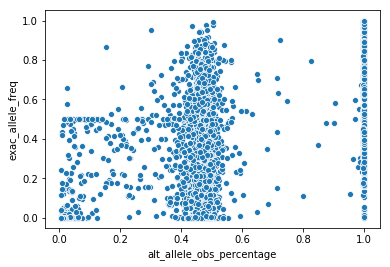

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the observed alt percentage against allele frequency from ExAC
exac_allele_freq = pd.to_numeric(df_with_exac['exac_allele_freq'].fillna(0))
ax = sns.scatterplot(x=df_with_exac.alt_allele_obs_percentage, y=exac_allele_freq)              

In [14]:
df_with_exac[output_column_order]

,chrom,pos,ref,alt,variant_type,read_depth,alt_allele_obs,alt_allele_obs_percentage,variant_str,exac_allele_count,exac_allele_freq,exac_allele_num,exac_hom_count,exac_pop_acs,exac_pop_ans,exac_pop_homs,exac_vep_annotations
0,1,931393,G,T,snp,4124,95,0.023036,1-931393-G-T,,,,,,,,
1,1,935222,C,A,snp,1134,652,0.575972,1-935222-C-A,51683,0.661111,78176,16403,"{'European (Non-Finnish)': 26919, 'East Asian'...","{'European (Non-Finnish)': 41512, 'East Asian'...","{'European (Non-Finnish)': 7903, 'East Asian':...","[{'SYMBOL': 'HES4', 'HGNC_ID': '24149', 'Codon..."
2,1,1277533,T,C,snp,786,786,1.000000,1-1277533-T-C,46411,0.997571,46524,23149,"{'European (Non-Finnish)': 25153, 'East Asian'...","{'European (Non-Finnish)': 25208, 'East Asian'...","{'European (Non-Finnish)': 12549, 'East Asian'...","[{'SYMBOL': 'DVL1', 'HGNC_ID': '3084', 'Codons..."
3,1,1284490,G,A,snp,228,228,1.000000,1-1284490-G-A,21065,0.897299,23476,9418,"{'European (Non-Finnish)': 10448, 'East Asian'...","{'European (Non-Finnish)': 11012, 'East Asian'...","{'European (Non-Finnish)': 4947, 'East Asian':...","[{'SYMBOL': 'DVL1', 'HGNC_ID': '3084', 'Codons..."
4,1,1571850,G,A,snp,4055,94,0.023181,1-1571850-G-A,1,1.11376e-05,89786,0,"{'European (Non-Finnish)': 1, 'East Asian': 0,...","{'European (Non-Finnish)': 49004, 'East Asian'...","{'European (Non-Finnish)': 0, 'East Asian': 0,...","[{'SYMBOL': 'CDK11B', 'HGNC_ID': '1729', 'Codo..."
5,1,1572579,A,G,snp,3456,26,0.007523,1-1572579-A-G,232,0.00217689,106574,2,"{'European (Non-Finnish)': 120, 'East Asian': ...","{'European (Non-Finnish)': 58884, 'East Asian'...","{'European (Non-Finnish)': 1, 'East Asian': 0,...","[{'SYMBOL': 'CDK11B', 'HGNC_ID': '1729', 'Codo..."
6,1,1575616,T,C,snp,1118,1118,1.000000,1-1575616-T-C,38538,0.843984,45662,16969,"{'European (Non-Finnish)': 24465, 'East Asian'...","{'European (Non-Finnish)': 26244, 'East Asian'...","{'European (Non-Finnish)': 11521, 'East Asian'...","[{'SYMBOL': 'CDK11B', 'HGNC_ID': '1729', 'Codo..."
7,1,1575784,C,T,snp,3476,266,0.076613,1-1575784-C-T,10265,0.0948864,108182,0,"{'European (Non-Finnish)': 2673, 'East Asian':...","{'European (Non-Finnish)': 61086, 'East Asian'...","{'European (Non-Finnish)': 0, 'East Asian': 0,...","[{'SYMBOL': 'CDK11B', 'HGNC_ID': '1729', 'Codo..."
8,1,1577180,C,T,snp,90,50,0.555556,1-1577180-C-T,42,0.488372,86,0,"{'European (Non-Finnish)': 35, 'East Asian': 4...","{'European (Non-Finnish)': 72, 'East Asian': 8...","{'European (Non-Finnish)': 0, 'East Asian': 0,...","[{'SYMBOL': 'CDK11B', 'HGNC_ID': '1729', 'Codo..."
9,1,1635004,T,C,snp,4076,4076,1.000000,1-1635004-T-C,52353,0.580487,90188,16226,"{'European (Non-Finnish)': 33871, 'East Asian'...","{'European (Non-Finnish)': 55844, 'East Asian'...","{'European (Non-Finnish)': 10372, 'East Asian'...","[{'SYMBOL': 'CDK11A', 'HGNC_ID': '1730', 'Codo..."
